<a href="https://colab.research.google.com/github/rushirajsherlocked/Awesome-Super-Resolution/blob/master/Normal_ESPN_Pruning_SuperRes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Dec 11 14:18:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [ ]:
path = untar_data(URLs.PETS, dest='/content/')
#path = Path('/opt/hubshare/vectorly-share/shared/Image Superresolution/Rushiraj/My-ESPCN-SuperRes/Rushi-ESPCN/BSD300/')
path_hr = path/'images'
path_lr = path/'small-128'
path_mr = path/'small-256'

path_512 = path/'Orig-512'
path_1024 = path/'Orig-1024'


#path_test = path/'test'

In [ ]:
# il = ImageList.from_folder(path_hr, convert_mode='YCbCr')
il = ImageList.from_folder(path_hr) 

In [ ]:
# Resize both the sides - Used for Resiziaing ORIGINAL IMAGES

def resize_two(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    #targ_sz = resize_to(img, size, use_min=True)
    #img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('YCbCr')
    img = img.resize((size,size), resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=100)

In [ ]:
def parallel_func(func, arr):
    with ThreadPoolExecutor(8) as ex:
        futures = ex.map(lambda x: func(x), arr)

In [ ]:
%%time
parallel_func(resize_two, il.items)


CPU times: user 195 ms, sys: 40.9 ms, total: 235 ms
Wall time: 235 ms


In [ ]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 128), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_two, path=p, size=size), il.items)

resizing to 128 into /content/oxford-iiit-pet/small-128


In [ ]:
# create smaller image sets the first time this nb is run
sets = [(path_512, 512), (path_1024, 1024)]
for p,size in sets:      
    if not p.exists():   
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_two, path=p, size=size), il.items)

resizing to 512 into /content/oxford-iiit-pet/Orig-512


In [ ]:
test = ImageList.from_folder(path_1024)

In [ ]:
test[24].shape

torch.Size([3, 1024, 1024])

In [ ]:
path_hr, path_lr, path_mr

(PosixPath('/content/oxford-iiit-pet/images'),
 PosixPath('/content/oxford-iiit-pet/small-128'),
 PosixPath('/content/oxford-iiit-pet/small-256'))

In [ ]:
il[1].shape

torch.Size([3, 500, 333])

In [ ]:
il[:100]

ImageList (100 items)
Image (3, 500, 500),Image (3, 500, 336),Image (3, 500, 375),Image (3, 225, 300),Image (3, 500, 375)
Path: /content/oxford-iiit-pet/images

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.prelu = nn.PReLU()
        self.conv1 = nn.Conv2d(3, 32, (3, 3), (1, 1), (1, 1))

        self.conv3 = nn.Conv2d(32, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, 3*upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.prelu(self.conv1(x))
        x = self.prelu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

if __name__ == "__main__":
    model = Net(upscale_factor=4).cuda()
    print(model)
    
    
    

Net(
  (prelu): PReLU(num_parameters=1)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=4)
)


In [ ]:
from torchsummary import summary

summary(model, (3, 320, 256))  # Channels = 3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 256]             896
             PReLU-2         [-1, 32, 320, 256]               1
            Conv2d-3         [-1, 32, 320, 256]           9,248
             PReLU-4         [-1, 32, 320, 256]               1
            Conv2d-5         [-1, 48, 320, 256]          13,872
      PixelShuffle-6        [-1, 3, 1280, 1024]               0
Total params: 24,018
Trainable params: 24,018
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.94
Forward/backward pass size (MB): 140.00
Params size (MB): 0.09
Estimated Total Size (MB): 141.03
----------------------------------------------------------------


In [ ]:
bs,size= 8, 128

src = ImageImageList.from_folder(path_lr)[:3000].split_by_rand_pct(0.1, seed=42)


In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_512/x.name)
           .databunch(bs=bs)).normalize(do_y=True)

    data.c = 3
    return data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

data = get_data(bs,size)

In [ ]:
# %%time
# means = [xb.mean(dim=(0, 2, 3)) for xb, yb in data.train_dl]
# stds = [xb.std(dim=(0, 2, 3)) for xb, yb in data.train_dl]
# mean, std = torch.stack(means).mean(dim=0), torch.stack(stds).mean(dim=0)
# print(mean, std)

In [ ]:
data

ImageDataBunch;

Train: LabelList (2700 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /content/oxford-iiit-pet/small-128;

Valid: LabelList (300 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: /content/oxford-iiit-pet/small-128;

Test: None

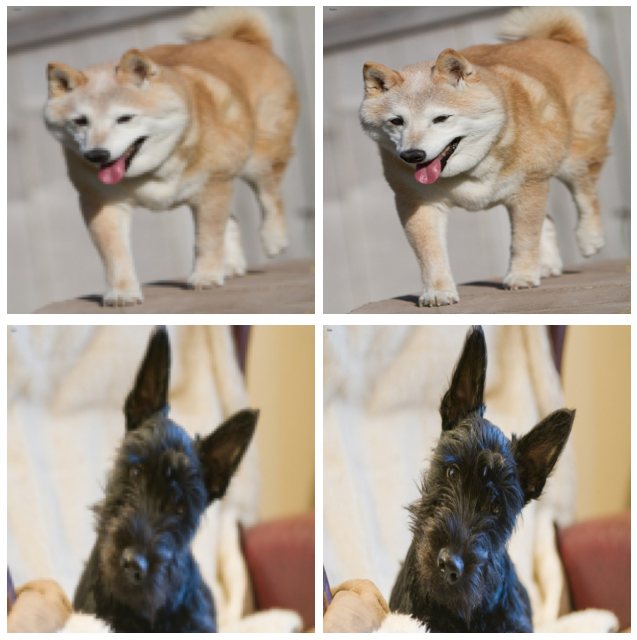

In [ ]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

# Feature Loss

In [ ]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [ ]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)


In [ ]:
gram_matrix(t)

tensor([[[0.0963, 0.0892, 0.0654],
         [0.0892, 0.0835, 0.0610],
         [0.0654, 0.0610, 0.0472]],

        [[0.0963, 0.0892, 0.0654],
         [0.0892, 0.0835, 0.0610],
         [0.0654, 0.0610, 0.0472]]])

In [ ]:
base_loss = F.l1_loss
#base_loss = nn.MSELoss()

In [ ]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [ ]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        
        self.feat_losses = [base_loss(input,target)] # The ERROR is here I guess
        
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [ ]:
base_loss = F.l1_loss
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

def calc_2_moments(tensor):
    chans = tensor.shape[1]
    tensor = tensor.view(1, chans, -1)
    n = tensor.shape[2]
    
    mu = tensor.mean(2)
    tensor = (tensor - mu[:,:,None]).squeeze(0)
    cov = torch.mm(tensor, tensor.t()) / float(n)
    
    return mu, cov

def get_style_vals(tensor):
    mean, cov = calc_2_moments(tensor)
    
    eigvals, eigvects = torch.symeig(cov, eigenvectors=True)
    
    eigroot_mat = torch.diag(torch.sqrt(eigvals.clamp(min=0)))
    
    root_cov = torch.mm(torch.mm(eigvects, eigroot_mat), eigvects.t())
    
    tr_cov = eigvals.clamp(min=0).sum()
    
    return mean, tr_cov, root_cov

def calc_l2wass_dist(mean_stl, tr_cov_stl, root_cov_stl, mean_synth, cov_synth):
    
    tr_cov_synth = torch.symeig(cov_synth, eigenvectors=True)[0].clamp(min=0).sum()
    
    mean_diff_squared = (mean_stl - mean_synth).pow(2).sum()
    
    cov_prod = torch.mm(torch.mm(root_cov_stl, cov_synth), root_cov_stl)
    
    var_overlap = torch.sqrt(torch.symeig(cov_prod, eigenvectors=True)[0].clamp(min=0)+1e-8).sum()
    
    dist = mean_diff_squared + tr_cov_stl + tr_cov_synth - 2*var_overlap
    
    return dist


def single_wass_loss(pred, targ):
    mean_test, tr_cov_test, root_cov_test = targ
    mean_synth, cov_synth = calc_2_moments(pred)
    loss = calc_l2wass_dist(mean_test, tr_cov_test, root_cov_test, mean_synth, cov_synth)
    return loss

class FeatureLoss_Wass(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts, wass_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.wass_wgts = wass_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'wass_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        
        styles = [get_style_vals(i) for i in out_feat]
        self.feat_losses += [single_wass_loss(f_pred, f_targ)*w
                            for f_pred, f_targ, w in zip(in_feat, styles, self.wass_wgts)]
        
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

feat_loss2 = FeatureLoss_Wass(vgg_m, blocks[2:15], [5,15,2,8,9,12,10,8,9,7,8,10,12], [3, 0.7, 0.01])

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


# Train

In [ ]:
wd = 1e-3

learn = Learner(data, model,  loss_func=feat_loss2, callback_fns= [LossMetrics]).load('/content/Filter_Pruned_26.48_1.38')

gc.collect();

In [ ]:
#learn.loss_func = nn.MSELoss()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,wass_0,wass_1,wass_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.10E-07


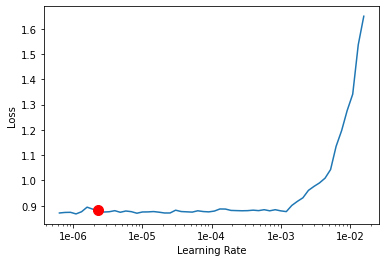

In [ ]:
learn.lr_find() 
learn.recorder.plot(suggestion=True) 

In [ ]:
from Pruner import *
from Sparsifier import *

In [ ]:
# Pruning type supported: "weights" and "filters".
bs, epochs = 4, 10
prune_meta = {
        "pruning_type": "filters",
        "starting_step" : 0,
        "current_step": 0,
        "ending_step": epochs * np.ceil(len(data.train_ds)/bs),
        "final_sparsity": 50,
        "initial_sparsity": 26.48,
        "span": 100
    }

In [ ]:
def fit_one_cycle_SP(epochs, lr, save_name, min_delta, pct_start=0.9):
    learn.fit_one_cycle(epochs, lr, pct_start=pct_start, 
                        callbacks=[SaveModelCallback(learn, every='improvement',
                                                     monitor='valid_loss', name=save_name),
                                   SparsifyCallback(learn, meta=prune_meta)])
    learn.show_results(rows=3, imgsize=5)

In [ ]:
from fastai.callbacks import EarlyStoppingCallback,SaveModelCallback

def fit_one_cycle(num_epochs:int, start_lr, save_name, min_delta):
    learn.fit_one_cycle(num_epochs, start_lr, pct_start=0.75, callbacks=[SaveModelCallback(learn, every='improvement',
                                                     monitor='valid_loss', name=save_name),
                                                EarlyStoppingCallback(learn, monitor='valid_loss', 
                                                         min_delta=min_delta, patience=3)])
    #learn.show_results(rows=3, imgsize=5)
    
    
    

def fit(num_epochs:int, lr, save_name):
    learn.fit(num_epochs, lr, callbacks=[SaveModelCallback(learn, every='improvement',
                                                     monitor='valid_loss', name=save_name),
                                                EarlyStoppingCallback(learn, monitor='valid_loss', 
                                                         min_delta=min_delta, patience=3)])
    #learn.show_results(rows=3, imgsize=5)



In [ ]:
lr = 1e-5
min_delta = 1e-6

fit_one_cycle(3, lr, 'model', min_delta)
learn.save('model', with_opt = False) 

In [ ]:
learn.model.eval()

Net(
  (prelu): PReLU(num_parameters=1)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=4)
)

In [ ]:
learn.save('Pruned_256_1.73') 

In [ ]:
lr = 1e-4
min_delta = 1e-4

fit_one_cycle_SP(10, lr, 'SP_model', min_delta) 
#learn.save('SP_model') 

Pruning of filters until a sparsity of 50%


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,wass_0,wass_1,wass_2,time
0,1.404546,1.429592,0.362809,0.235526,0.260389,0.097527,0.325169,0.082895,0.065277,06:31
1,1.877947,1.830916,0.398957,0.244436,0.275124,0.102570,0.632687,0.109651,0.067490,06:31
2,1.620632,1.601270,0.459471,0.240498,0.268418,0.099690,0.377633,0.089408,0.066154,06:30
3,1.644556,1.614793,0.515962,0.242622,0.267661,0.099996,0.329825,0.090560,0.068167,06:30


Better model found at epoch 0 with valid_loss value: 1.429592251777649.
Sparsity: 28.34%
Sparsity: 29.81%
Sparsity: 31.22%
Sparsity: 32.55%


In [ ]:
learn.model.conv1.weight

Parameter containing:
tensor([[[[-1.5507e-03,  3.7049e-03,  3.1527e-03],
          [ 6.2420e-03,  1.1058e-02,  7.1675e-03],
          [ 3.8516e-03,  7.0455e-03,  1.5438e-03]],

         [[-1.0288e-03,  5.4999e-03,  7.2049e-03],
          [ 6.7125e-03,  1.3146e-02,  1.1502e-02],
          [ 1.0990e-03,  6.2518e-03,  4.3827e-03]],

         [[-4.4763e-03,  1.3365e-03,  3.0238e-03],
          [ 4.3014e-03,  8.1939e-03,  7.0993e-03],
          [ 4.0544e-03,  6.5899e-03,  3.0423e-03]]],


        [[[-8.0994e-02,  1.4803e-01,  8.2609e-02],
          [ 2.6388e-01,  3.6261e-01,  8.4295e-02],
          [-1.5579e-01, -1.3291e-01, -1.8353e-01]],

         [[-4.7444e-02, -1.6048e-01,  3.4302e-01],
          [-6.7875e-02, -2.6245e-01,  1.0683e-01],
          [ 6.8956e-02, -2.0237e-01, -2.1196e-01]],

         [[ 5.7351e-02,  4.5254e-02,  9.6509e-03],
          [-2.4955e-01, -6.3131e-01,  5.5177e-02],
          [ 2.2780e-01,  1.6747e-01,  1.5637e-01]]],


        [[[ 7.9137e-02, -4.1210e-02,  2.6555

In [ ]:
learn.model_dir = '/content/'

In [ ]:
learn.save('Pruned_128_All_0.86')

In [ ]:
learn.save('PyTorch_Pruned_128_All_0.86', with_opt = False)

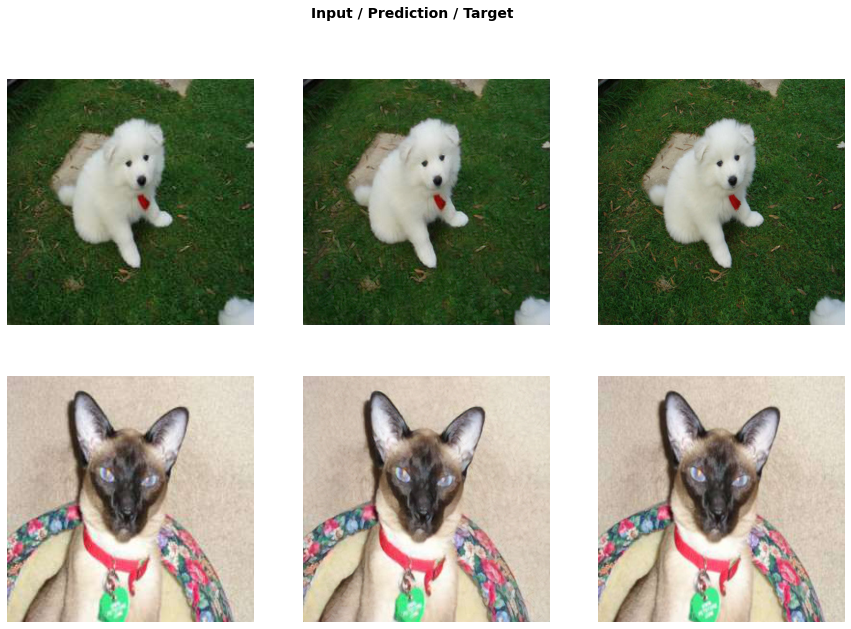

In [ ]:
learn.show_results(rows=3, imgsize=5)

In [ ]:
len(learn.layer_groups)

1

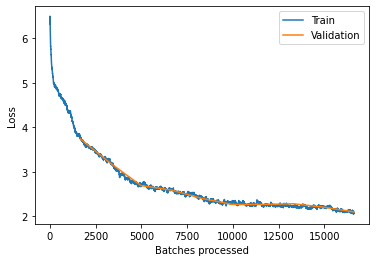

In [ ]:
learn.recorder.plot_losses()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

data = get_data(10,size*4)

In [ ]:
learn.data = data
gc.collect()

learn.load('/content/All_256_0.8');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


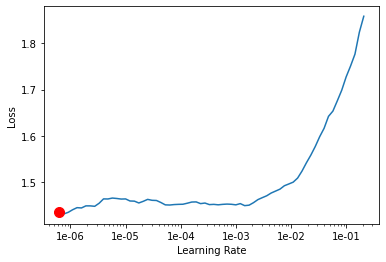

In [ ]:
learn.lr_find(num_it=100)
learn.recorder.plot(suggestion=True) 

In [ ]:
lr = 1e-6
min_delta = 1e-2

fit_one_cycle(5, lr, 'model3', min_delta)

In [ ]:
learn.model_dir = '/content/'

In [ ]:
learn.save('Normal_ALL_128_0.97')

In [ ]:
learn.export('/opt/hubshare/vectorly-share/shared/Image Superresolution/Rushiraj/My-ESPCN-SuperRes/Rushi-ESPCN/export.pkl')

In [ ]:
lr = 1e-06

fit(5, lr, 'model2')

# Pruning

In [ ]:
pruner = Pruner()

In [ ]:
cpu_model = learn.model.cpu()
pruned_model = pruner.prune_model(cpu_model)

In [ ]:
new_learn = Learner(data, pruned_model, loss_func=feat_loss2, callback_fns= [LossMetrics])

In [ ]:
learn.validate()

[0.7376427]

In [ ]:
learn.summary()

Net
Layer (type)         Output Shape         Param #    Trainable 
PReLU                [32, 128, 128]       1          True      
______________________________________________________________________
Conv2d               [32, 128, 128]       896        True      
______________________________________________________________________
Conv2d               [32, 128, 128]       9,248      True      
______________________________________________________________________
Conv2d               [48, 128, 128]       13,872     True      
______________________________________________________________________
PixelShuffle         [3, 512, 512]        0          False     
______________________________________________________________________

Total params: 24,017
Total trainable params: 24,017
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FeatureLo

In [ ]:
new_learn.summary()

Net
Layer (type)         Output Shape         Param #    Trainable 
PReLU                [32, 128, 128]       1          True      
______________________________________________________________________
Conv2d               [32, 128, 128]       896        True      
______________________________________________________________________
Conv2d               [32, 128, 128]       9,248      True      
______________________________________________________________________
Conv2d               [48, 128, 128]       13,872     True      
______________________________________________________________________
PixelShuffle         [3, 512, 512]        0          False     
______________________________________________________________________

Total params: 24,017
Total trainable params: 24,017
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FeatureLo

In [ ]:
new_learn.validate()

[0.7376427]

In [ ]:
new_learn.summary()

RuntimeError: ignored

# Inference

### .pth model

In [ ]:
bs,size=2,256

src = ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)

data2 = (src.label_from_func(lambda x: path_1024/x.name)
           .databunch(bs=bs))

wd = 1e-3

learn = Learner(data2, model).load('/content/Normal_model_0.9')
# , loss_func=feat_loss, callback_fns=LossMetrics


gc.collect();


learn.data = data2

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:458: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [ ]:
learn.load('Normal_256_model_3K_0.8');

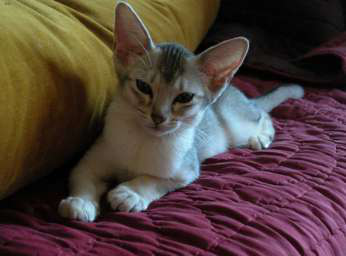

In [ ]:
img = open_image('Abyssinian_26.jpg')
img


In [ ]:
# For frame size 256 X 256 ----- > 1024 X 1024 (4X) ---> 0.01 sec ----> 100 FPS

import time

start_time = time.time()

_,img_hr,b = learn.predict(img)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.03481125831604004 seconds ---


In [ ]:
%%time
import cv2

img_np = img_hr.numpy()
img_np = np.uint8(255*np.clip(img_np, 0, 1))
img_np = np.moveaxis(img_np, 0, -1)
img_np = np.moveaxis(img_np, 0, 1)

img_np = np.flipud(np.rot90(img_np))
img_np = img_np[:, :, ::-1]
cv2.imwrite("test-t.png", img_np)

CPU times: user 101 ms, sys: 25.1 ms, total: 126 ms
Wall time: 746 ms


In [ ]:
test = ImageList.from_folder(path_lr)

In [ ]:
import torchvision.transforms as tfms

def pil2fast(img):  
  return Image(tfms.ToTensor()(img))

def fast2pil(img):
  return tfms.ToPILImage()(img.data).convert("RGB")  


In [ ]:
img = fast2pil(test[4])
img
img.save('Orig.png')

In [ ]:
# For frame size 256 X 256 ----- > 1024 X 1024 (4X) ---> 0.01 sec ----> 100 FPS

import time

start_time = time.time()

_,img_hr,b = learn.predict(test[4])

print("--- %s seconds ---" % (time.time() - start_time))

img = fast2pil(img_hr)

img.save('test.png')

--- 0.012811899185180664 seconds ---


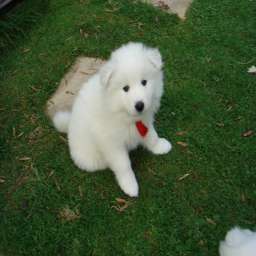

In [ ]:
fn = data.valid_ds.x.items[0]; fn
img = open_image(fn)
img

In [ ]:
# For frame size 256 X 256 ----- > 1024 X 1024 (4X) ---> 0.01 sec ----> 100 FPS

import time

start_time = time.time()

_,img_hr,b = learn.predict(img)

print("--- %s seconds ---" % (time.time() - start_time))


img = fast2pil(img_hr)

img.save('test.png')

--- 0.023106098175048828 seconds ---


In [ ]:
# out_img *= 255.0
# out_img = out_img.clip(0, 255)
# out_img = np.transpose(out_img,(1,2,0))
# out_img = np.uint8(out_img)

# out_img = Image.fromarray(out_img, mode='RGB')
# out_img.save(opt.output_filename)

### .pkl model

In [ ]:
learn = load_learner(Path('/opt/hubshare/vectorly-share/shared/Image Superresolution/Rushiraj/My-ESPCN-SuperRes/Rushi-ESPCN/'), 'export.pkl')

In [ ]:
# For frame size 256 X 256 (W x H)

import time

start_time = time.time()

_,img_hr,b = learn.predict(img)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.01116180419921875 seconds ---


### CONCLUSION: No time difference between .pth and .pkl model